<a href="https://colab.research.google.com/github/kirtanag/analysis/blob/main/Exploring_trends_in_Apple_AirPods_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Insights into consumers' opinions about a product is vital in product improvement. In this limited experiment, I aim to analyse a small dataset of reviews left by Apple AirPods users. The data is segemented based on how long the customer has used the product. <br>

The dataset has 2 broad categories of reviews-
1. Reviews mentioning the Apple ecosystem
2. Other reviews, which for the purpose of this analysis, have been considered to be reviews left by customers who do not place importance on  the product's integration into the Apple ecosystem

I will pick out some key topics mentioned in the reviews, and create a heatmap which explores the prevalence of said topic within each dataset as well as the combined dataset.

I also test a small hypothesis that members of the Apple ecosystem are more likely to say positive things about the AirPods. Will this hold true?

# Packages

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
import numpy as np
from datetime import datetime
import pandas as pd
import seaborn as sns
import plotly.express as px
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import os
from os import path
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
import plotly.graph_objects as go
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Scraping the reviews

Scraping reviews mentioning ecosystem off of BestBuy <br>

Randomly scraping 140 pages and sampling from them

In [ ]:
total_pages = 3465
# We can scrape 140 random pages and randomly pull two reviews each from each scraped page
import random
random.seed(9001)
pages_to_be_scraped = [random.randint(1, total_pages+1) for _ in range(140)]
print(len(pages_to_be_scraped))
print(pages_to_be_scraped[:10])

140
[152, 1236, 1037, 280, 2311, 1028, 2332, 3358, 2483, 2102]


In [ ]:
# Defining a function to scrape BestBuy
date_format = "%b %d, %Y %I:%M %p"
def extract_review_data(data, pages):
    review_page_number = []
    ratings = []
    title = []
    posting_date = []
    used_for = []
    review_body = []
    whether_recommended = []

    for idx, soup in enumerate(data, start = 0):
      review_box = soup.find_all('li', class_='review-item')
      review_page_number.extend([pages[idx]] * len(review_box))
      for review in review_box:
          ratings.append(int(review.find('div', class_='c-ratings-reviews').find('p', class_='visually-hidden').text.replace('Rated ', '').replace(' out of 5 stars', '')))
          title.append(review.find('h4', class_='c-section-title review-title heading-5 v-fw-medium').text)
          date_string = review.find('time', class_='submission-date')['title']
          posting_date.append(datetime.strptime(date_string, date_format))
          try:
              used_for.append(review.find('div', class_='posted-date-ownership').get_text(strip=True).split("Owned for")[1].split("when reviewed.")[0])
          except:
              used_for.append('Not Available')
          review_body.append(review.find('div', class_='ugc-review-body').find('p').text.strip())
          recommendation_text = review.find('div', class_='ugc-recommendation').get_text(strip=True)
          if "wouldrecommend" in recommendation_text:
              whether_recommended.append(1)
          elif "wouldnot" in recommendation_text:
              whether_recommended.append(0)
          else:
              whether_recommended.append('Not Available')
    return {
        'Review_Page_Number': review_page_number,
        'Ratings': ratings,
        'Title': title,
        'Posting_Date': posting_date,
        'Used_For': used_for,
        'Review_Body': review_body,
        'Whether_Recommended': whether_recommended
    }

In [ ]:
# Scraping
base_url = "https://www.bestbuy.com/site/reviews/apple-airpods-with-charging-case-2nd-generation-white/6084400?variant=A&page={}"

header = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:79.0) Gecko/20100101 Firefox/79.0'}

raw_data = []
total_pages = len(pages_to_be_scraped)

# Create a tqdm progress bar for the loop
for page_number in tqdm(pages_to_be_scraped, desc="Scraping Progress", ncols=100, ascii=True, total=total_pages):
    url = base_url.format(page_number)

    # Send a GET request to the URL
    response = requests.get(url, headers=header)

    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')
    if 'access' and 'denied' in str(soup).lower():
        print("Stopping the loop.")
        break

    raw_data.append(soup)

    # Add a delay to avoid overwhelming the server with requests
    time.sleep(round(random.uniform(0.1, 3), 2))

# The scraping is completed, and the progress bar is at 100%
print("Scraping completed!")


Scraping Progress: 100%|##########################################| 140/140 [07:47<00:00,  3.34s/it]

Scraping completed!


In [ ]:
review_samples = extract_review_data(raw_data, pages_to_be_scraped)
print(len(review_samples))

7


In [ ]:
# Create a dataframe with all the reviews
df_samples = pd.DataFrame(review_samples)
df_samples.to_csv('all_reviews.csv')
df_samples.head()

,Review_Page_Number,Ratings,Title,Posting_Date,Used_For,Review_Body,Whether_Recommended
0,152,5,Apple ear pod.,2023-06-30 18:16:00,1 month,These ear pods are great and work for prefect....,1
1,152,5,Airpods,2023-07-26 12:36:00,2 weeks,"I love that airpods, this ones are my second p...",1
2,152,5,Sue's Pods,2023-06-30 14:54:00,6 months,Love them. Just have to be careful to not loos...,1
3,152,5,Air pods,2023-06-19 10:11:00,1 year,I love the air pods. My grandson said: nana. t...,1
4,152,5,Airpods,2023-07-20 20:37:00,1 month,What can i say. There airpods not much to day ...,0


In [ ]:
# Scraping the reviews with ecosystem mentioned
base_url_2 = 'https://www.bestbuy.com/site/reviews/apple-airpods-with-charging-case-2nd-generation-white/6084400?variant=A&searchText=ecosystem%20OR%20eco-system%20OR%20echo%20system%20OR%20eco%20system&sort=BEST_MATCH&page={}'
header = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:79.0) Gecko/20100101 Firefox/79.0'}

raw_data_2 = []
pages_to_be_scraped_2 = range(1,15)
total_pages = len(pages_to_be_scraped_2)

# Create a tqdm progress bar for the loop
for page_number in tqdm(pages_to_be_scraped_2, desc="Scraping Progress", ncols=100, ascii=True, total=total_pages):
    url = base_url_2.format(page_number)

    # Send a GET request to the URL
    response = requests.get(url, headers=header)

    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')
    if 'access' and 'denied' in str(soup).lower():
        print("Stopping the loop.")
        break

    raw_data_2.append(soup)

    # Add a delay to avoid overwhelming the server with requests
    time.sleep(round(random.uniform(0.1, 3), 2))

# The scraping is completed, and the progress bar is at 100%
print("Scraping completed!")


Scraping Progress: 100%|############################################| 14/14 [00:43<00:00,  3.13s/it]

Scraping completed!


In [ ]:
review_ecosystem = extract_review_data(raw_data_2, pages_to_be_scraped_2)
print(len(review_ecosystem))

7


In [ ]:
# Create a dataframe with all the reviews
df_ecosystem = pd.DataFrame(review_ecosystem)
print(len(df_ecosystem))
df_ecosystem.to_csv('all_eco_system_reviews.csv')
df_ecosystem.head()

263


,Review_Page_Number,Ratings,Title,Posting_Date,Used_For,Review_Body,Whether_Recommended
0,1,5,Apple eco system,2021-06-06 16:48:00,1 year,Great product. Yes it may not be the best but ...,1
1,1,2,Pay for the EcoSystem,2021-08-06 15:37:00,3 weeks,For the money there are better options . Other...,1
2,1,4,Great for the Apple Eco-System,2021-11-18 18:04:00,3 months,Solid product to go with the Apple eco-system....,1
3,1,4,Great set for the Apple eco system,2020-01-06 14:26:00,3 weeks,They are just what you would expect from an Ap...,1
4,1,5,Best airpod,2023-07-06 18:41:00,2 months,Best airpod 2 gen really good works with apple...,1


# Reloading downloaded data

In [ ]:
df_samples = pd.read_csv('all_reviews.csv')
df_ecosystem = pd.read_csv('all_eco_system_reviews.csv')
df_ecosystem.head()

,Unnamed: 0,Review_Page_Number,Ratings,Title,Posting_Date,Used_For,Review_Body,Whether_Recommended
0,0,1,5,Apple eco system,2021-06-06 16:48:00,1 year,Great product. Yes it may not be the best but ...,1
1,1,1,2,Pay for the EcoSystem,2021-08-06 15:37:00,3 weeks,For the money there are better options . Other...,1
2,2,1,4,Great for the Apple Eco-System,2021-11-18 18:04:00,3 months,Solid product to go with the Apple eco-system....,1
3,3,1,4,Great set for the Apple eco system,2020-01-06 14:26:00,3 weeks,They are just what you would expect from an Ap...,1
4,4,1,5,Best airpod,2023-07-06 18:41:00,2 months,Best airpod 2 gen really good works with apple...,1


# Pruning samples down to 263 items
## Logic for selection -
I have 140 sets of 20 reviews each. I want to be as widespread with my selection as possible to minimise clusters of reviews. <br>
So, I will go with 1 unique review picked from 17 pages, and 2 reviews picked from 123 pages <br>
Count the number of reviews from each page <br>
Randomly select 17 unique pages and other pages <br>

In [ ]:
unique_pages = random.sample(pages_to_be_scraped, 17)
other_pages = [item for item in pages_to_be_scraped if item not in unique_pages]

def samples(group):
    number = 2 if group.name in other_pages else 1
    return group.sample(n=min(number, len(group)), random_state=22)

# Group the DataFrame by 'Review_Page_Number' and sample reviews from each group
df_samples_subset = df_samples.groupby('Review_Page_Number', group_keys=False, sort=False).apply(samples)
remaining_samples = 263 - len(df_samples_subset)
additional_samples = df_samples.sample(n=remaining_samples, random_state=22)
df_samples_subset = pd.concat([df_samples_subset, additional_samples], ignore_index=True)

print(len(df_samples_subset))
df_samples_subset.head()

263


,Unnamed: 0,Review_Page_Number,Ratings,Title,Posting_Date,Used_For,Review_Body,Whether_Recommended
0,10,152,5,Great,2023-06-28 13:22:00,7 months,Was great for i need. I lost my onld one and t...,1
1,14,152,5,Solid purchase!,2023-06-03 04:40:00,3 weeks,Easily syncs to both my iPhone and Mac almost ...,1
2,30,1236,5,I brought for my sister,2020-07-26 17:10:00,2 weeks,I got these for my sister for her birthday and...,1
3,34,1236,5,good buy,2020-11-23 23:47:00,4 months,gifted them to a friend and she loves using th...,1
4,50,1037,5,Power in my ear!,2021-02-20 01:07:00,Not Available,"Love my headphones, literally go everywhere wi...",1


# Exploratory Data Analysis 1 - Average Ratings

I wanted to explore whether members of the Apple ecosystem would be more likely to be critical or supportive of Apple AirPods

In [ ]:
# Average Ratings
samples_rating = df_samples_subset['Ratings'].value_counts().reset_index()
samples_rating['Nature'] = np.repeat('Random Samples', len(samples_rating))
ecosystem_rating = df_ecosystem['Ratings'].value_counts().reset_index()
ecosystem_rating['Nature'] = np.repeat('Ecosystem Reviews', len(ecosystem_rating))
df_rating = pd.concat([samples_rating, ecosystem_rating])
df_rating

,index,Ratings,Nature
0,5,235,Random Samples
1,4,22,Random Samples
2,1,2,Random Samples
3,2,2,Random Samples
4,3,2,Random Samples
0,5,202,Ecosystem Reviews
1,4,50,Ecosystem Reviews
2,3,8,Ecosystem Reviews
3,2,2,Ecosystem Reviews
4,1,1,Ecosystem Reviews


In [ ]:
print(f'The average rating left by members of the ecosystem was: {round(df_ecosystem["Ratings"].mean(), 2)} out of 5')
print(f'The average rating left by others was: {round(df_samples["Ratings"].mean(), 2)} out of 5')
print('Hence, the Hypothesis does not hold true.')

The average rating left by members of the ecosystem was: 4.71 out of 5
The average rating left by others was: 4.83 out of 5
Hence, the Hypothesis does not hold true.


In [ ]:
# % of variation
variation_percent = -(round(((df_ecosystem["Ratings"].mean()-df_samples["Ratings"].mean())/df_ecosystem["Ratings"].mean())*100,2))
variation_percent

2.44

In [ ]:
# Visualising
ratings_order = [1,2,3,4,5]

fig = px.bar(df_rating, x="Nature", y="Ratings", color='index', title="Apple AirPods User Rating",
             width=600, labels={"value": "Review Counts", 'variable': 'Selection'})

fig.update_layout(title_x=0.5, yaxis={'categoryorder':'array', 'categoryarray': ratings_order})
fig.update_traces(marker_line_width=0)
fig.update_traces(width=0.5)
fig.show()

# Exploratory Data Analysis 2 - Word Count Plot

I wanted to quickly visualise the most common words used within the 2 datasets, and hence, have created Word Count Plots where the size of the word shows its prevalence

In [ ]:
# Cleaning reviews to remove stop words
def cleaning(x):
    x = " ".join(x.split())
    x = str(x).lower()
    return x

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.replace("’", "").translate(translator)

stops = set(stopwords.words('english'))
new_stopwords = ['like', 'one', "cant", "really", 'said', 'get', 'went', 'even', 'told', 'could', 'apple', 'would', 'see', "thats", "im", "i m", 'got', 'airpods', 'good', 'great', 'love', 'loves']
stops = stops.union(new_stopwords)

# Lemmatizing each row of the cleaned text
# Function
# Lemmatizing and Tokenizing
lemmatizer = WordNetLemmatizer()
def lemm(x):
    removed_stop_lemma = []
    tokens1 = word_tokenize(x)
    for i in range(len(tokens1)):
        removed_stop_lemma.append(lemmatizer.lemmatize(tokens1[i]))
    toto = " ".join(removed_stop_lemma)
    return toto

def clean_pipeline(text):
    # Converting text to lowercase
    text = cleaning(text)
    # Punctuation
    text = remove_punctuation(text)
    # Stop words
    text = ' '.join("" if p in stops else p for p in text.split())
    # Lemmatizing the text
    text = lemm(text)
    text = ' '.join("" if i in stops else i for i in text.split())
    return text

In [ ]:
# Cleaned reviews
tqdm.pandas()
df_samples_subset['text_cleaned'] = df_samples_subset['Review_Body'].progress_apply(lambda x: clean_pipeline(x))
df_ecosystem['text_cleaned'] = df_ecosystem['Review_Body'].progress_apply(lambda x: clean_pipeline(x))

100%|██████████| 263/263 [00:00<00:00, 4598.46it/s]


In [ ]:
counts_sample = Counter(" ".join(df_samples_subset['text_cleaned']).split()).most_common(1000)
counts_sample
counts_sample_df= pd.DataFrame(counts_sample)
counts_sample_df

,0,1
0,sound,75
1,quality,50
2,easy,48
3,use,47
4,work,42
...,...,...
748,workout,1
749,wait,1
750,future,1
751,jack,1


In [ ]:
counts_ecosystem = Counter(" ".join(df_ecosystem['text_cleaned']).split()).most_common(1000)
counts_ecosystem_df= pd.DataFrame(counts_ecosystem)
counts_ecosystem_df

,0,1
0,sound,131
1,ecosystem,118
2,system,97
3,quality,78
4,work,76
...,...,...
995,purchaser,1
996,wellintegrated,1
997,confused,1
998,getso,1


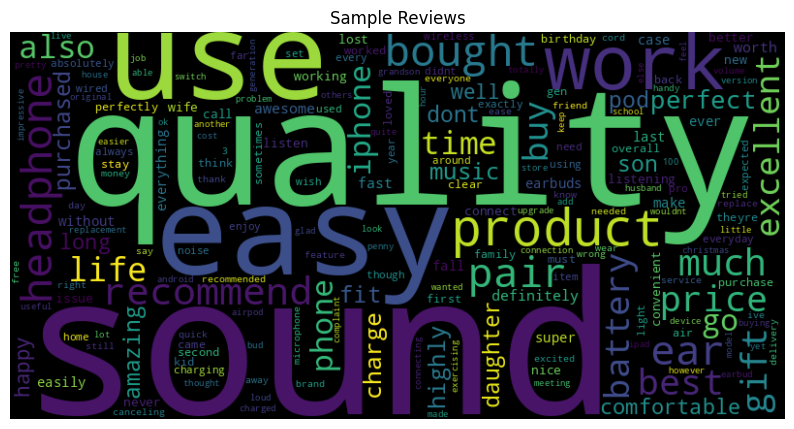

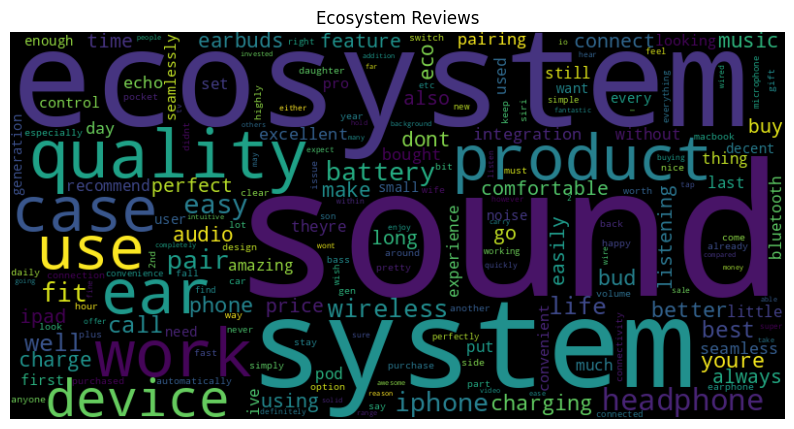

In [ ]:
# Plotting word frequency plot
dataplot = dict(zip(counts_sample_df[0].tolist(), counts_sample_df[1].tolist()))
dataplot_2 = dict(zip(counts_ecosystem_df[0].tolist(), counts_ecosystem_df[1].tolist()))
# Generate a word cloud image
wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(dataplot)
wc2 = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(dataplot_2)
# Display the generated image:
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Sample Reviews')
plt.show()
# Display the generated image:
plt.figure(figsize=(10, 10))
plt.imshow(wc2, interpolation='bilinear')
plt.axis('off')
plt.title('Ecosystem Reviews')
plt.show()

# Exploratory Data Analysis 3 - Heatmap of common words

To get a more granular look on what members of the ecosystem versus others talk about relating to the Apple AirPods based on how long they've used the product

There are 4 buckets of product usage -
1. Less than 1 month
2. More than 1 month but Less than 6 months
3. More than 6 months
4. Unknown (Data Not Available)

In [ ]:
# Exploring the most common words used in both sets of reviews, and creating a correlation matrix
common_words = list(set(list(counts_sample_df[0].iloc[:23])+list(counts_ecosystem_df[0].iloc[:23])))
print(common_words)

['product', 'iphone', 'go', 'also', 'device', 'recommend', 'use', 'easy', 'sound', 'well', 'excellent', 'time', 'life', 'battery', 'quality', 'ecosystem', 'wireless', 'gift', 'headphone', 'buy', 'call', 'system', 'fit', 'bought', 'pair', 'much', 'work', 'ear', 'price', 'best', 'better', 'case', 'phone']


In [ ]:
# Removing words that don't add much value -
words_to_be_removed = ['much', 'better', 'system', 'ecosystem', 'well', 'also', 'best', 'excellent']
common_words = [word for word in common_words if word not in words_to_be_removed]

In [ ]:
len(common_words)

25

In [ ]:
df_samples_subset['DataFrame'] = 'Sample Reviews'
df_ecosystem['DataFrame'] = 'Ecosytem Reviews'

# Concatenate data frames and create a multi-level index
df_both = pd.concat([df_samples_subset, df_ecosystem])

# Reset the index to flatten it
df_both.reset_index(level=0, inplace=True)

In [ ]:
for word in common_words:
    df_both[word] = df_both['text_cleaned'].apply(lambda x: 1 if isinstance(x, str) and word in x else 0)

In [ ]:
# Bucket the 'Used for' data
buckets = {"1 year" : "> 6 months", "3 weeks" : "< 1 month", "3 months" : "1 - 6 month(s)", "2 months" : "1 - 6 month(s)", "2 weeks" : "< 1 month", "1 month" : "1 - 6 month(s)", "7 months" : "> 6 months", "Not Available" : "Unknown", "5 months" : "1 - 6 month(s)", "less than 1 week" : "< 1 month", "4 months" : "1 - 6 month(s)", "1 week" : "< 1 month", "6 months" : "> 6 months", "1.5 years" : "> 6 months", "8 months" : "> 6 months", "more than 2 years" : "> 6 months", "10 months" : "> 6 months", "11 months" : "> 6 months", "9 months" : "> 6 months"}
df_both['Buckets'] = df_both['Used_For'].map(buckets)

In [ ]:
df_both.head()

,index,Unnamed: 0,Review_Page_Number,Ratings,Title,Posting_Date,Used_For,Review_Body,Whether_Recommended,text_cleaned,...,call,fit,bought,pair,work,ear,price,case,phone,Buckets
0,0,10,152,5,Great,2023-06-28 13:22:00,7 months,Was great for i need. I lost my onld one and t...,1,need lost onld another,...,0,0,0,0,0,0,0,0,0,> 6 months
1,1,14,152,5,Solid purchase!,2023-06-03 04:40:00,3 weeks,Easily syncs to both my iPhone and Mac almost ...,1,easily syncs iphone mac almost instantaneously...,...,0,0,0,0,0,0,0,0,1,< 1 month
2,2,30,1236,5,I brought for my sister,2020-07-26 17:10:00,2 weeks,I got these for my sister for her birthday and...,1,sister birthday well thanks,...,0,0,0,0,0,0,0,0,0,< 1 month
3,3,34,1236,5,good buy,2020-11-23 23:47:00,4 months,gifted them to a friend and she loves using th...,1,gifted friend using daily basis,...,0,0,0,0,0,0,0,0,0,1 - 6 month(s)
4,4,50,1037,5,Power in my ear!,2021-02-20 01:07:00,Not Available,"Love my headphones, literally go everywhere wi...",1,headphone literally go everywhere highly recom...,...,0,0,0,0,0,0,0,0,1,Unknown


In [ ]:
# Create an empty DataFrame to store summed values
summed_df = df_both.groupby(['DataFrame', 'Buckets']).sum()
summed_df.reset_index(inplace=True)
summed_df = summed_df.drop(columns = ['index', 'Review_Page_Number', 'Ratings', 'Whether_Recommended', 'Unnamed: 0'])
summed_df.head()

<ipython-input-29-fd89f9a470c5>:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,DataFrame,Buckets,product,iphone,go,device,recommend,use,easy,sound,...,buy,call,fit,bought,pair,work,ear,price,case,phone
0,Ecosytem Reviews,1 - 6 month(s),17,15,15,12,8,28,14,39,...,13,14,13,9,16,19,28,7,17,35
1,Ecosytem Reviews,< 1 month,22,17,10,14,7,19,19,42,...,5,11,15,4,14,25,33,11,10,34
2,Ecosytem Reviews,> 6 months,9,4,3,11,1,14,7,16,...,4,4,4,1,5,17,11,4,9,13
3,Ecosytem Reviews,Unknown,11,5,3,6,5,11,6,19,...,2,8,6,3,10,11,12,3,2,20
4,Sample Reviews,1 - 6 month(s),12,9,6,1,9,22,25,31,...,9,3,2,8,14,18,22,10,3,25


In [ ]:
# Melt the DataFrame
melted_df = pd.melt(summed_df, id_vars=['DataFrame', 'Buckets'], var_name='Feature', value_name='Count')
melted_df.reset_index(drop=True, inplace=True)
melted_df['Nature'] =  melted_df['DataFrame'] + ": " + melted_df['Buckets']
melted_df.head()

,DataFrame,Buckets,Feature,Count,Nature
0,Ecosytem Reviews,1 - 6 month(s),product,17,Ecosytem Reviews: 1 - 6 month(s)
1,Ecosytem Reviews,< 1 month,product,22,Ecosytem Reviews: < 1 month
2,Ecosytem Reviews,> 6 months,product,9,Ecosytem Reviews: > 6 months
3,Ecosytem Reviews,Unknown,product,11,Ecosytem Reviews: Unknown
4,Sample Reviews,1 - 6 month(s),product,12,Sample Reviews: 1 - 6 month(s)


In [ ]:
# Creating a dataframe for Ecosystem  Reviews
mdf = melted_df[melted_df['DataFrame']=='Ecosytem Reviews']
mdf = mdf.drop(columns=['DataFrame'])
# Creating a dataframe for Other  Reviews
mdf2 = melted_df[melted_df['DataFrame']!='Ecosytem Reviews']
mdf2 = mdf2.drop(columns=['DataFrame'])

In [ ]:
# Calculating percentage for each Bucket + Feature combination since the buckets have uneven counts and we do not want to bias the heatmap
mdf['Total_Count'] = mdf.groupby(['Buckets'])['Count'].transform('sum')
mdf['Percentage'] = (mdf['Count'] / mdf['Total_Count']) * 100
mdf.drop(columns=['Total_Count'], inplace=True)
mdf = mdf.sort_values(by=['Buckets', 'Feature'])
mdf.head()

# Calculating percentage for each Bucket + Feature combination since the buckets have uneven counts and we do not want to bias the heatmap
mdf2['Total_Count'] = mdf2.groupby(['Buckets'])['Count'].transform('sum')
mdf2['Percentage'] = (mdf2['Count'] / mdf2['Total_Count']) * 100
mdf2.drop(columns=['Total_Count'], inplace=True)
mdf2 = mdf2.sort_values(by=['Buckets', 'Feature'])
mdf2.head()

,Buckets,Feature,Count,Nature,Percentage
84,1 - 6 month(s),battery,8,Sample Reviews: 1 - 6 month(s),2.787456
148,1 - 6 month(s),bought,8,Sample Reviews: 1 - 6 month(s),2.787456
124,1 - 6 month(s),buy,9,Sample Reviews: 1 - 6 month(s),3.135889
132,1 - 6 month(s),call,3,Sample Reviews: 1 - 6 month(s),1.045296
188,1 - 6 month(s),case,3,Sample Reviews: 1 - 6 month(s),1.045296


In [ ]:
# Creating a dataframe with both groups of data
overall_data = melted_df.groupby(['Buckets', 'Feature']).sum()
overall_data.reset_index(inplace=True)

# Calculating percentage for each Bucket + Feature combination since the buckets have uneven counts and we do not want to bias the heatmap
overall_data['Total_Count'] = overall_data.groupby(['Buckets'])['Count'].transform('sum')
overall_data['Percentage'] = (overall_data['Count'] / overall_data['Total_Count']) * 100
overall_data.drop(columns=['Total_Count'], inplace=True)
overall_data = overall_data.sort_values(by=['Buckets', 'Feature'])
overall_data.head()

<ipython-input-34-d0ac0bff858c>:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Buckets,Feature,Count,Percentage
0,1 - 6 month(s),battery,20,2.915452
1,1 - 6 month(s),bought,17,2.478134
2,1 - 6 month(s),buy,22,3.206997
3,1 - 6 month(s),call,17,2.478134
4,1 - 6 month(s),case,20,2.915452


## Heatmap-

Use the dropdown list within the heatmap to see how the word counts change for-
1. Ecosystem users
2. Others
3. Both together

In [ ]:
# Create heatmap traces
heatmap_trace1 = go.Heatmap(
    x=mdf['Feature'],
    y=mdf['Buckets'],
    z=mdf['Percentage'],
    type='heatmap',
    colorscale='Viridis',
    colorbar=dict(title='Percentage'),
    name='Heatmap 1'.upper()
)

heatmap_trace2 = go.Heatmap(
    x=mdf2['Feature'],
    y=mdf2['Buckets'],
    z=mdf2['Percentage'],
    type='heatmap',
    colorscale='Viridis',
    colorbar=dict(title='Percentage'),
    name='Heatmap 2'.upper()
)

heatmap_trace3 = go.Heatmap(
    x=overall_data['Feature'],
    y=overall_data['Buckets'],
    z=overall_data['Percentage'],
    type='heatmap',
    colorscale='Viridis',
    colorbar=dict(title='Percentage'),
    name='Overall Heatmap'.upper()
)

# Set up dropdown menu
buttons = []
for i, label in enumerate(['Heatmap 1', 'Heatmap 2', 'Overall Heatmap']):
    visibility = [i == j for j in range(3)]
    button = dict(label=label.upper(),
                  method='update',
                  args=[{'visible': visibility},
                        {'title': label, 'title_x' : 0.5}])
    buttons.append(button)

updatemenus = list([
    dict(active=0,
         buttons=buttons,
         x=0.1,
         y=1.15)
])

# Create layout with annotations and dropdown menu
layout = go.Layout(
    title='Normalized Data Heatmap'.upper(),
    title_x=0.5,
    title_xanchor='center',
    xaxis=dict(title='Feature'),
    yaxis=dict(title='Bucket'),
    updatemenus=updatemenus
)

# Create figure and add traces
fig = go.Figure(data=[heatmap_trace1, heatmap_trace2, heatmap_trace3], layout=layout)

# Show the heatmap
fig.show()

In [ ]:
fig.write_html("AirPodsInteractiveHeatmap.html")

# Conclusion

1. Based on EDA 1, we know that members of the Apple ecosystem are around 2.5% more likely to give a lower rating to Apple AirPods than others.

2. Based on EDA 2, we see some words being used very frequently across the datasets. They are- <br>
[i] Ecosystem reviews - Ecosystem, Product, Sound, Quality <br>
[ii] Other reviews - *Use, Quality, Easy, Sound *

3. The heatmap is a rich data source. Some key conclusions from it include: <br>
[a] Overall, a lot of users talk about the product's ***sound quality***, as well as ***phone*** (presumably about connecting to their phone) <br>
[b] Unsurprisingly, members of the ecosystem talk about ***sound quality*** more than other reviewers. <br>
[c] There is a non-trivial downward movement of the mention of ***quality*** in the overall heatmap as time progresses. <br>
[d] More people talk about how the AirPods ***work*** more than 6 months into using it
